In [1]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.mlab as mlab

## Helper functions

In [2]:
def save_variable_to_file(name, filename):
    named_variable = [v for v in tf.trainable_variables() if v.name == name][0]    
    named_variable_np_array = named_variable.eval()
    
    with open(filename, "w") as outfile:
        np.save(outfile, named_variable_np_array)
    print('Variable: {} saved to file'.format(name))


In [136]:
model = 'log-uniform_FIXED_MNIST'
model_path = '../../models/mnf/mnf_{}/'.format(model)

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('{}mnf.meta'.format(model_path))
    saver.restore(sess, tf.train.latest_checkpoint(model_path))

#     for v in tf.global_variables():
#         print(v)

#     save_variable_to_file("fq2_fr2_usezTrue/densemnf_1/mean_W:0", "../../models/mnf/weights/mean_layer1_{}.npz".format(model))
#     save_variable_to_file("fq2_fr2_usezTrue/densemnf_1/var_W:0", "../../models/mnf/weights/var_layer1_{}.npz".format(model))

#     save_variable_to_file("fq2_fr2_usezTrue/densemnf_2/mean_W:0", "../../models/mnf/weights/mean_layer2_{}.npz".format(model))
#     save_variable_to_file("fq2_fr2_usezTrue/densemnf_2/var_W:0", "../../models/mnf/weights/var_layer2_{}.npz".format(model))

INFO:tensorflow:Restoring parameters from ../../models/mnf/mnf_log-uniform_FIXED_MNIST/mnf


In [3]:
def plot_function(weights, subset=True, savefile=None):
    '''
    Plot heatmaps
    '''
    if subset:
        weights = weights[:50, :50]    
    plt.clf()
    plt.imshow(weights)
    plt.colorbar()
    
    if savefile is not None:
        plt.savefig(savefile)

def plot_function_2(weights, savefile=None):
    masked_array = np.ma.masked_where(weights == 0.0, weights)

    cmap = matplotlib.cm.spring  # Can be any colormap that you want after the cm
    cmap.set_bad(color='black')

    plt.clf()
    plt.imshow(masked_array, cmap=cmap)
#     plt.colorbar(im)
#     plt.show()

    if savefile is not None:
        plt.savefig(savefile)
    plt.show()

## Results on the MNIST data

In [ ]:
weights = np.load("../../models/mnf/weights/layer1_std-normal.npz")
plot_function(weights)

In [ ]:
weights = np.load("../../models/mnf/weights/layer1_cauchy_10-epochs.npz")
plot_function(weights)

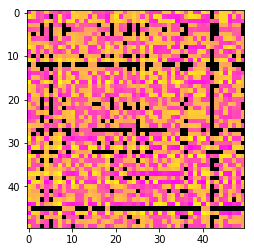

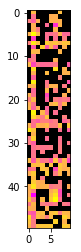

Number of zeros: 2352/5000


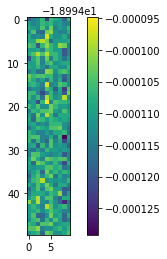

In [122]:
cutoff_threshold = 1

# ************************************* Layer 1 *************************************

# >>>>> Mean Weights
mean_weights_1 = np.load("../../models/mnf/weights/mean_layer1_{}.npz".format(model))
mean_weights_1[(mean_weights_1 >= -cutoff_threshold) & (mean_weights_1 <= cutoff_threshold)] = 0.0

mean_weights_1_1 = mean_weights_1[:50, :50]
mean_weights_1_2 = mean_weights_1[220:270, :50]
mean_weights_1_3 = mean_weights_1[350:400, :50]
plot_function_2(mean_weights_1_1, savefile='../../results/log-uniform_dense1_thres-1.png')

# plot_function(mean_weights_1, subset = False)

# >>>>> Var Weights
# var_weights_1 = np.load("../../models/mnf/weights/var_layer1_{}.npz".format(model))
# plot_function(var_weights_1)

# ************************************* Layer 2 *************************************

# >>>>> Mean Weights

cutoff_threshold = .1

mean_weights_2 = np.load("../../models/mnf/weights/mean_layer2_{}.npz".format(model))
mean_weights_2[(mean_weights_2 >= -cutoff_threshold) & (mean_weights_2 <= cutoff_threshold)] = 0.0

mean_weights_2_1 = mean_weights_2[:50, :]
mean_weights_2_2 = mean_weights_2[220:270, :]
mean_weights_2_3 = mean_weights_2[350:400, :]
plot_function_2(mean_weights_2_1, savefile='../../results/log-uniform_dense2_thres-0.1.png')

x_axis_range = 500
y_axis_range = 10
count = 0
for i in range(x_axis_range):
    for j in range(y_axis_range):
        if mean_weights_2[i, j] >= -.1 and mean_weights_2[i, j] <= .1:
            count += 1

print('Number of zeros: {}/{}'.format(count, x_axis_range * y_axis_range))

# >>>>> Var Weights
var_weights_2 = np.load("../../models/mnf/weights/var_layer2_{}.npz".format(model))

var_weights_2_1 = var_weights_2[:50, :]
var_weights_2_2 = var_weights_2[220:270, :]
var_weights_2_3 = var_weights_2[350:400, :]
plot_function(var_weights_2_1, subset=False)

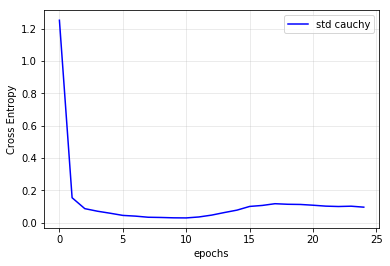

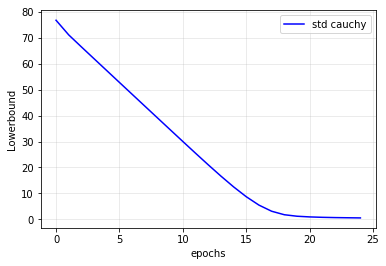

In [6]:
# Entropies and lowerbounds

# std normal
# with open('../../models/mnf/mnist_standard_normal', 'rb') as f:
#     dictionary_sn = pickle.load(f)

# # log uniform
# with open('../../models/mnf/mnist_log_uniform', 'rb') as f:
#     dictionary_lu = pickle.load(f)

# # std cauchy
with open('../../models/mnf/mnist_standard_cauchy', 'rb') as f:
    dictionary_sc = pickle.load(f)


plt.grid(alpha=.3)
# ax_a = plt.plot(dictionary_sn['entropies'], c='red', label='std normal')
# ax_b = plt.plot(dictionary_lu['entropies'], c='green', label='log uniform')
ax_c = plt.plot(dictionary_sc['entropies'], c='blue', label='std cauchy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Cross Entropy')

plt.figure()
plt.grid(alpha=.3)
# ax_a = plt.plot(dictionary_sn['lowerbounds'], c='red', label='std normal')
ax_c = plt.plot(dictionary_sc['lowerbounds'], c='blue', label='std cauchy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Lowerbound')
plt.savefig('../../results/lowerbound_normal_cauchy.png')

In [32]:
def entropy_predictive_distribution(distribution):
    '''
    Compute entropy for (disrete) predictive distribution
    '''
    entropy = 0
    for p in distribution:
        if p != 0.0:
            entropy += (-p * np.log(p))

    return entropy

def plot_entropy_histogram(preds, name, cumulative=True, histtype='step'):
    '''
    Plot histogram of entropy of predictive distritbution
    '''
    entropies = []
    for pred in preds:
        entropies.append(entropy_predictive_distribution(pred))

    bins = np.linspace(0, 2.5, 50).tolist()
    bins = bins + [np.inf]
    n, x, _ = plt.hist(entropies, bins=bins, cumulative=cumulative, histtype=histtype, label=name, density=True, stacked=True)

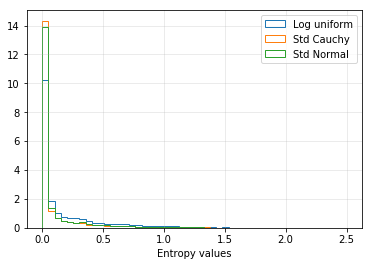

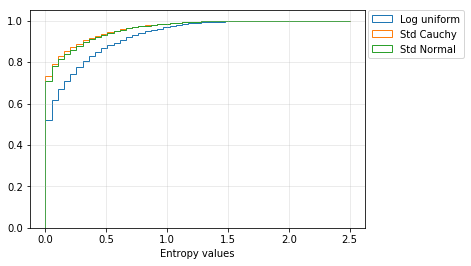

In [33]:
# MNIST - MNIST

preds_log_uniform = np.load('../../models/mnf/mnist_log_uniform_preds_experiment_1')
preds_std_cauchy = np.load('../../models/mnf/mnist_standard_cauchy_preds_experiment_1')
preds_std_normal = np.load('../../models/mnf/mnist_standard_normal_preds_experiment_1')

plt.grid(alpha=.3)
plot_entropy_histogram(preds_log_uniform, 'Log uniform', cumulative=False)
plot_entropy_histogram(preds_std_cauchy, 'Std Cauchy', cumulative=False)
plot_entropy_histogram(preds_std_normal, 'Std Normal', cumulative=False)
plt.xlabel('Entropy values')
plt.legend()

plt.figure()
plt.grid(alpha=.3)
plot_entropy_histogram(preds_log_uniform, 'Log uniform')
plot_entropy_histogram(preds_std_cauchy, 'Std Cauchy')
plot_entropy_histogram(preds_std_normal, 'Std Normal')

plt.xlabel('Entropy values')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

Since the test set is MNIST, the classes are known. This results in small entropies as shown in top figure. The bottom figure shows the empirical Cumulative distribution.

(10000, 28, 28)
(10000,)


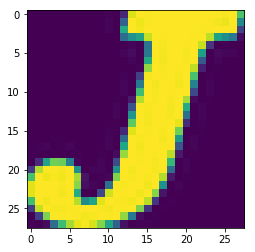

In [90]:
# create notMNIST dataset

def create_not_mnist_data():
    xtest = np.load('../../data/mnist/xtest')
    ytest = np.load('../../data/mnist/ytest')

    print xtest.shape
    print ytest.shape

    plt.imshow(xtest[2])

    data_test = {
        'xtest': xtest,
        'ytest': ytest
    }

    with open('../../data/mnist/notmnist_test.pkl', 'wb') as f:
        pickle.dump(data_test, f)

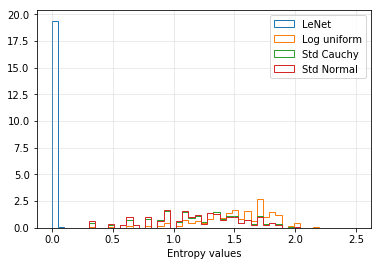

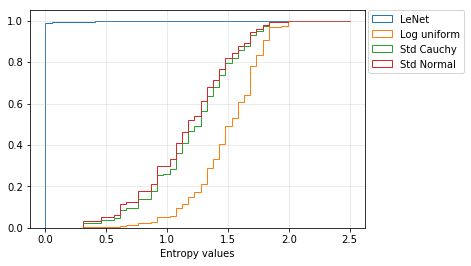

In [35]:
# MNIST - notMNIST

lenet_preds = np.load('../../models/lenet/preds_experiment_4_notmnist')
preds_log_uniform = np.load('../../models/mnf/mnist_log_uniform_preds_experiment_4')
preds_std_cauchy = np.load('../../models/mnf/mnist_standard_cauchy_preds_experiment_4')
preds_std_normal = np.load('../../models/mnf/mnist_standard_normal_preds_experiment_4')

plt.grid(alpha=.3)
plot_entropy_histogram(lenet_preds, 'LeNet', cumulative=False)
plot_entropy_histogram(preds_log_uniform, 'Log uniform', cumulative=False)
plot_entropy_histogram(preds_std_cauchy, 'Std Cauchy', cumulative=False)
plot_entropy_histogram(preds_std_normal, 'Std Normal', cumulative=False)
plt.xlabel('Entropy values')
plt.legend()

plt.figure()
plt.grid(alpha=.3)
plot_entropy_histogram(lenet_preds, 'LeNet')
plot_entropy_histogram(preds_log_uniform, 'Log uniform')
plot_entropy_histogram(preds_std_cauchy, 'Std Cauchy')
plot_entropy_histogram(preds_std_normal, 'Std Normal')

plt.xlabel('Entropy values')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

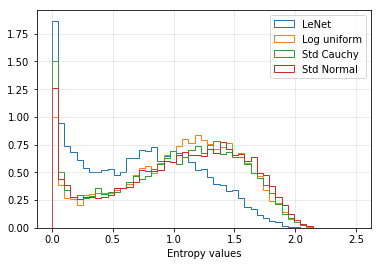

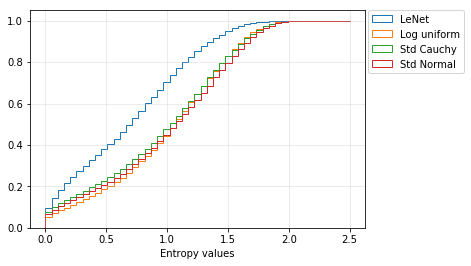

In [37]:
# MNIST - MNIST-rot

lenet_preds = np.load('../../models/lenet/preds_experiment_3_rotMNIST')
preds_log_uniform = np.load('../../models/mnf/mnist_log_uniform_preds_experiment_3')
preds_std_cauchy = np.load('../../models/mnf/mnist_standard_cauchy_preds_experiment_3')
preds_std_normal = np.load('../../models/mnf/mnist_standard_normal_preds_experiment_3')

plt.grid(alpha=.3)
plot_entropy_histogram(lenet_preds, 'LeNet', cumulative=False)
plot_entropy_histogram(preds_log_uniform, 'Log uniform', cumulative=False)
plot_entropy_histogram(preds_std_cauchy, 'Std Cauchy', cumulative=False)
plot_entropy_histogram(preds_std_normal, 'Std Normal', cumulative=False)
plt.xlabel('Entropy values')
plt.legend()

plt.figure()
plt.grid(alpha=.3)
plot_entropy_histogram(lenet_preds, 'LeNet')
plot_entropy_histogram(preds_log_uniform, 'Log uniform')
plot_entropy_histogram(preds_std_cauchy, 'Std Cauchy')
plot_entropy_histogram(preds_std_normal, 'Std Normal')

plt.xlabel('Entropy values')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [19]:
# Toy Regression data

num_points = 20
x = np.random.uniform(-4, 4, num_points)

y = []
for i in x:
    y_i = i**3 + np.random.normal(0, 9)
    y.append(y_i)

y = np.array(y)

print y

[  6.58419994 -19.3486365   11.72818305 -17.9428005   57.80276432
  11.61199858  11.78440539  -5.71224184 -10.27338889  14.2304895
   3.71400436 -11.14135413   2.52373755 -12.04587067   3.08638841
 -12.86277965 -33.68717429   9.44175896  -7.84373096 -41.51925585]


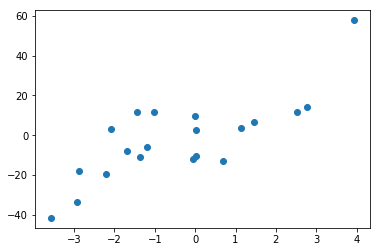

In [20]:
plt.scatter(x, y)

In [ ]:
weights = np.load("../../models/mnf/weights/layer1_log-uniform_clipped-alpha.npz")
plot_function(weights)

In [ ]:
weights = np.load("../../models/mnf/weights/layer1_log-uniform_recent.npz")
weights = weights[:50, :50]
weights[(weights >= -1) & (weights <= 1)] = 0.0
plot_function_2(weights)

In [ ]:
mean_weights = np.load("../../models/mnf/weights/mean_layer1_log-uniform_clipped-alpha.npz")
var_weights = np.load("../../models/mnf/weights/var_layer1_log-uniform_clipped-alpha.npz")

# mean_weights = mean_weights[:50, :50]
# var_weights = var_weights[:50, :50]

mean_weights[(mean_weights >= -1) & (mean_weights <= 1)] = 0.0

# print(mean_weights)

count = 0
for i in range(800):
    for j in range(500):
#         if var_weights[i, j] < -14:
        if mean_weights[i, j] == var_weights[i, j]:
            count += 1
            mean_weights[i, j] = 0.0

print(count)
# plot_function_2(mean_weights)
plot_function_2(mean_weights)

In [137]:
from mnist import MNIST
from keras.utils.np_utils import to_categorical

mnist = MNIST()
(xtrain, ytrain), (xvalid, yvalid), (xtest, ytest) = mnist.images()
xtrain, xvalid, xtest = np.transpose(xtrain, [0, 2, 3, 1]), np.transpose(xvalid, [0, 2, 3, 1]), np.transpose(xtest, [0, 2, 3, 1])
ytrain, yvalid, ytest = to_categorical(ytrain, 10), to_categorical(yvalid, 10), to_categorical(ytest, 10)

In [144]:
from wrappers import MNFLeNet


weights = np.load("../../models/mnf/weights/mean_layer2_log-uniform_FIXED_MNIST.npz")
weights[(weights >= -.1) & (weights <= .1)] = 0.0


# N, height, width, n_channels = xtrain.shape
# iter_per_epoch = N / 100
# input_shape = [None, height, width, n_channels]
# model = MNFLeNet(N, input_shape=input_shape, flows_q=2, flows_r=2, use_z=False,
#                  learn_p=True, thres_var=0.5, flow_dim_h=50)

# x = tf.placeholder(tf.float32, input_shape, name='x')
# y_ = tf.placeholder(tf.float32, [None, 10], name='y_')
# y = model.predict(x)
# yd = model.predict(x, sample=False)
# pyx = tf.nn.softmax(y)

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('../../models/mnf/TEST/mnf.meta')
    saver.restore(sess, tf.train.latest_checkpoint('../../models/mnf/TEST/'))

    w = [v for v in tf.trainable_variables() if v.name == "fq2_fr2_usezTrue/densemnf_2/mean_W:0"][0]
    w_new = w.assign(tf.convert_to_tensor(weights))
    sess.run(w_new)

#     for v in tf.global_variables():
#         print(v)
    
#     preds = np.zeros_like(ytest)
#     for i in xrange(10):
#         for j in xrange(xtest.shape[0] / 100):
#             pyxi = sess.run(pyx, feed_dict={x: xtest[j * 100:(j + 1) * 100]})
#             preds[j * 100:(j + 1) * 100] += pyxi / 10
#     print
#     sample_accuracy = np.mean(np.equal(np.argmax(preds, 1), np.argmax(ytest, 1)))
#     print '  - Sample test accuracy: {}'.format(sample_accuracy)

INFO:tensorflow:Restoring parameters from ../../models/mnf/TEST/mnf


## Results on the CIFAR-10 data

In [3]:
from cifar10 import CIFAR10
from keras.utils.np_utils import to_categorical

cifar10 = CIFAR10()
(xtrain, ytrain), (xvalid, yvalid), (xtest, ytest) = cifar10.images()
xtrain, xvalid, xtest = np.transpose(xtrain, [0, 2, 3, 1]), np.transpose(xvalid, [0, 2, 3, 1]), np.transpose(xtest, [0, 2, 3, 1])
ytrain, yvalid, ytest = to_categorical(ytrain, 10), to_categorical(yvalid, 10), to_categorical(ytest, 10)

print xtrain.shape

(40000, 32, 32, 3)


In [7]:
# weights = np.load("../../models/mnf/weights/layer1_log-uniform_10-epochs_cifar10.npz")
import cPickle as pickle
with open('../../data/cifar10/data_batch_1', 'rb') as f:
    cifar = pickle.load(f)

(10000, 3072)
(32, 32, 3)


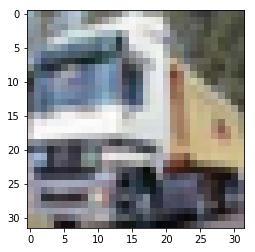

In [15]:

data = cifar['data']
print data.shape

n = np.reshape(data, (data.shape[0], 3, 32, 32))

xtrain = np.transpose(n, [0, 2, 3, 1])

print xtrain[1].shape

plt.imshow(xtrain[1])


# single_image = np.array(data[1])
# single_image_reshaped = np.transpose(np.reshape(single_image,(3, 32, 32)), (1, 2, 0))
# # print(single_image)
# # plt.imshow(single_image_reshaped)
# print single_image_reshaped.shape

In [ ]:
from mnist import MNIST
from keras.utils.np_utils import to_categorical

mnist = MNIST()
(xtrain, ytrain), (xvalid, yvalid), (xtest, ytest) = mnist.images()
print xtrain.shape
xtrain, xvalid, xtest = np.transpose(xtrain, [0, 2, 3, 1]), np.transpose(xvalid, [0, 2, 3, 1]), np.transpose(xtest, [0, 2, 3, 1])
ytrain, yvalid, ytest = to_categorical(ytrain, 10), to_categorical(yvalid, 10), to_categorical(ytest, 10)

print xtrain.shape
print ytrain.shape